<div style="text-align:center"><img src="https://www.dropbox.com/s/roovx0dx8mpm4ep/ECE4076_banner.png?dl=1"></div>

<h1 align="center"> ECE4076/5176 - Week 11 </h1>
<h1 align="center"; style="color: purple;"> Fun with Region-Based CNN (RCNN) </h1>



You need to have the following packages to work with this notebook
- [pytorch](https://pytorch.org/)
- [OpenCV](https://pypi.org/project/opencv-python/)
- [numpy](https://anaconda.org/anaconda/numpy)
- [matplotlib](https://anaconda.org/conda-forge/matplotlib)
- [pillow](https://pillow.readthedocs.io/en/stable/)




In [17]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

import time
from datetime import timedelta
import requests






# import warnings
# warnings.filterwarnings('ignore')
%matplotlib inline



In [23]:
# the following function reads an image from a URL and displays it.
def read_image_from_url(url):
    img = Image.open(requests.get(url, stream=True).raw)
    # img.thumbnail((256,256), Image.ANTIALIAS)
    return np.array(img)[:,:,[2,1,0]]

# Selective Search for Object Detection

In [24]:
# Load the image
image_path = "data/clayton.jpg"
url = "https://www.monash.edu/__data/assets/image/0006/959496/clayton-campus-green-chemical-futures-building-exterior2017.jpg"
image = read_image_from_url(url)

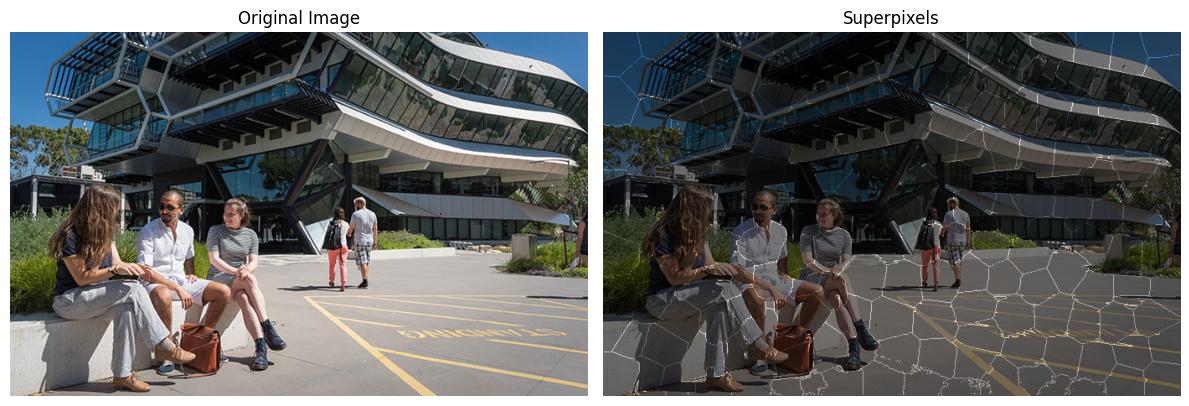

In [25]:


# Convert the image to Lab color space
lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)

# Create the superpixel object
region_size = 40

# This may need you to install the package opencv-conrib-python
superpixel = cv2.ximgproc.createSuperpixelSLIC(lab_image, algorithm=cv2.ximgproc.SLICO, region_size=region_size)

# Perform the superpixel segmentation
superpixel.iterate()

# Get the labels of the superpixels
labels = superpixel.getLabels()

# Create a mask for the superpixel boundaries
mask = superpixel.getLabelContourMask()

# Apply the mask on the original image to show the superpixel boundaries
image_with_boundaries = cv2.bitwise_and(image, image, mask=mask)
image_with_overlay = image.copy()

# Apply an alpha blend effect by merging the image with boundaries using the mask
alpha = 0.5  # Adjust the alpha value for desired blending effect
image_with_overlay = cv2.addWeighted(image, 1-alpha, image_with_boundaries, alpha, 0)



# Display the results
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Display the original image
axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axs[0].set_title("Original Image")
axs[0].axis("off")

# Display the image with superpixel 
axs[1].imshow(cv2.cvtColor(image_with_overlay, cv2.COLOR_BGR2RGB))
axs[1].set_title("Superpixels")
axs[1].axis("off")


plt.tight_layout()
plt.show()


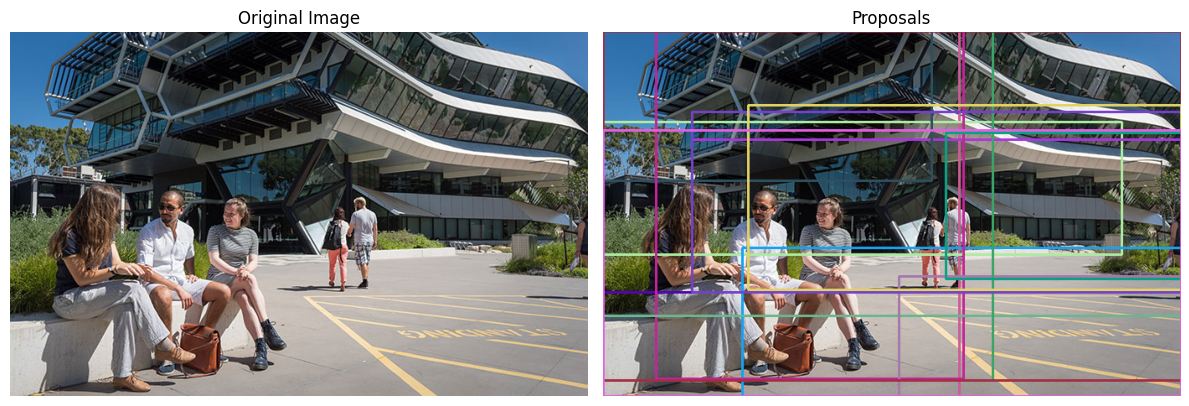

In [27]:
# Create a Selective Search segmentation object
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

# Set the input image for selective search
ss.setBaseImage(image)

# Perform selective search
ss.switchToSelectiveSearchFast()  # Use fast mode for efficiency
proposals = ss.process()

image_with_proposals = image.copy()
# Show the top 15 region proposals
num_proposals = 15
colors = np.random.randint(0, 255, (num_proposals, 3), dtype=np.uint8)
for i, proposal in enumerate(proposals[-num_proposals:]):
    x, y, w, h = proposal
    color = tuple(map(int, colors[i]))
    cv2.rectangle(image_with_proposals, (x, y), (x+w, y+h), color, 2)

# Display the image with object proposals
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Display the original image
axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axs[0].set_title("Original Image")
axs[0].axis("off")

# Display the image with superpixel boundaries
axs[1].imshow(cv2.cvtColor(image_with_proposals, cv2.COLOR_BGR2RGB))
axs[1].set_title("Proposals")
axs[1].axis("off")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()




In [28]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


In [30]:
COCO_INSTANCE_CATEGORY_NAMES = ['__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
                                'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
                                'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
                                'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
                                'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
                                'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
                                'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
                                'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
                                'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
                                'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
                                'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
                                'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
                                ]


det_COLORS = np.random.uniform(0, 255, size=(len(COCO_INSTANCE_CATEGORY_NAMES), 3))

In [31]:
from torchvision.models import detection

# load the model and set it to evaluation mode
model = detection.fasterrcnn_resnet50_fpn(pretrained=True).to(device)
model.eval()

/home/michael/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/michael/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [32]:
# the following function reads an image from a URL and displays it.
def read_image_from_url(url):
    pil_img = Image.open(requests.get(url, stream=True).raw)
    pil_img.thumbnail((800, 600), Image.ANTIALIAS)
    #img_thumbnail = img.thumbnail((256,256), Image.ANTIALIAS)
    plt.imshow(pil_img)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    img = np.array(pil_img)

    torch_img = prepare_img_torch(img)
    return torch_img, img



def prepare_img_torch(img):
    img = img/255.0
    img = img.transpose((2, 0, 1))
    # add the batch dimension, scale the raw pixel intensities to the
    # range [0, 1], and convert the image to a floating point tensor
    img = np.expand_dims(img, axis=0)
    torch_img = torch.FloatTensor(img)
    # send the input to the device and pass the it through the network to
    # get the detections and predictions
    torch_img = torch_img.to(device)
    return torch_img


def draw_text(img, text,
          font=cv2.FONT_HERSHEY_PLAIN,
          pos=(0, 0),
          font_scale=3,
          font_thickness=2,
          text_color=(255, 255, 255),
          text_color_bg=(0, 0, 0)
          ):

    x, y = pos
    text_size, _ = cv2.getTextSize(text, font, font_scale, font_thickness)
    text_w, text_h = text_size
    cv2.rectangle(img, pos, (x + text_w, y + text_h), text_color_bg, -1)    
    cv2.putText(img, text, (x, y + text_h + font_scale - 1), font, font_scale, text_color, font_thickness)

    return text_size

/tmp/ipykernel_4058763/1996857105.py:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  pil_img.thumbnail((800, 600), Image.ANTIALIAS)


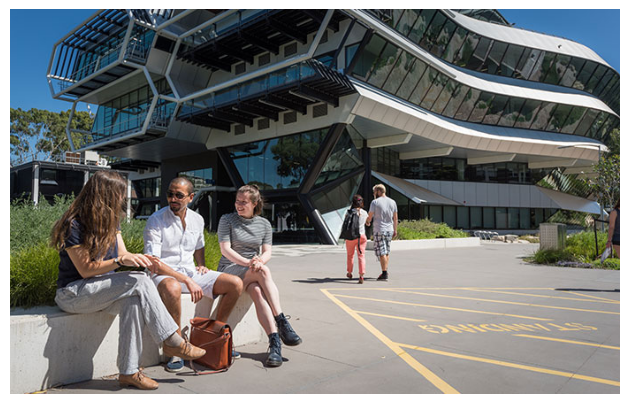

In [33]:
# url = "http://cdn.cnn.com/cnnnext/dam/assets/200130092551-02-market-street-san-francisco-car-free-now.jpg"
# url = "https://m.media-amazon.com/images/I/71xybHPToQL._AC_SL1500_.jpg"
url = "https://www.monash.edu/__data/assets/image/0006/959496/clayton-campus-green-chemical-futures-building-exterior2017.jpg"

img, img_rgb = read_image_from_url(url)

In [34]:
predictions = model(img)[0]

pred_scores = predictions["scores"].detach().cpu().numpy()
pred_classes = predictions["labels"].detach().cpu().numpy()
pred_boxes = predictions["boxes"].detach().cpu().numpy().astype(int)

In [35]:
import pandas as pd
df = pd.DataFrame(pred_boxes, columns = ["x","y","w","h"])
df["Confidence Scores"] = pred_scores
# df["Classes"] = [obj_class for obj_class in COCO_INSTANCE_CATEGORY_NAMES[pred_classes]
df["Classes"] = [COCO_INSTANCE_CATEGORY_NAMES[idx] for idx in pred_classes]
print(df)


      x    y    w    h  Confidence Scores     Classes
0   232  197  327  396           0.999319      person
1    45  183  221  427           0.998770      person
2   403  197  439  306           0.997966      person
3   371  208  405  308           0.995380      person
4   152  188  259  377           0.968915      person
5   195  341  253  410           0.962195     handbag
6   668  217  688  283           0.882104      person
7   372  225  396  260           0.588682    backpack
8   370  225  393  262           0.473462     handbag
9    15  311  252  426           0.464389       bench
10   10  328  155  429           0.429357       bench
11  112  191  222  375           0.342157      person
12   48  183  162  361           0.274194      person
13   91  277  300  393           0.203477       bench
14  383  229  395  258           0.196141         tie
15  375  228  387  257           0.185814         tie
16  148  193  224  331           0.178832      person
17  377  228  391  255      

An object from the class person is found with a confidence score of 99.93
An object from the class person is found with a confidence score of 99.88
An object from the class person is found with a confidence score of 99.80
An object from the class person is found with a confidence score of 99.54
An object from the class person is found with a confidence score of 96.89
An object from the class handbag is found with a confidence score of 96.22
An object from the class person is found with a confidence score of 88.21
An object from the class backpack is found with a confidence score of 58.87
An object from the class handbag is found with a confidence score of 47.35
An object from the class bench is found with a confidence score of 46.44
An object from the class bench is found with a confidence score of 42.94
An object from the class person is found with a confidence score of 34.22


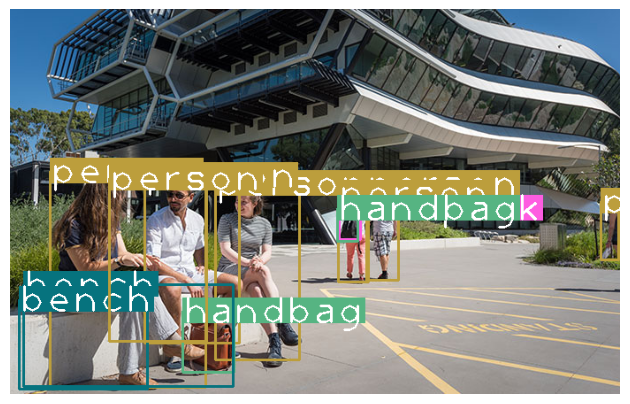

In [36]:
plt_img = img_rgb.copy()
conf_threshold = 0.3


# loop over the detections
for confidence, idx, bb in zip(pred_scores, pred_classes, pred_boxes):
	# print(confidence, COCO_INSTANCE_CATEGORY_NAMES[idx])

	# filter out weak detections by ensuring the confidence is
	# greater than the minimum confidence
	if confidence > conf_threshold:
		# extract the index of the class label from the detections,
		# then compute the (x, y)-coordinates of the bounding box
		# for the object
		obj_class = COCO_INSTANCE_CATEGORY_NAMES[idx]
		(startX, startY, endX, endY) = bb.astype("int")
		# display the prediction to our terminal
		print(f"An object from the class {obj_class} is found with a confidence score of {(confidence*100):.2f}")
		# draw the bounding box and label on the image
		cv2.rectangle(plt_img, (startX, startY), (endX, endY),	det_COLORS[idx], 2)
		y = startY - 15 if startY - 15 > 15 else startY + 15
		# cv2.putText(plt_img, obj_class, (startX, y),	cv2.FONT_HERSHEY_PLAIN, 2, det_COLORS[idx], 2)
		# cv2.putText(plt_img, obj_class, (startX, y),	cv2.FONT_HERSHEY_PLAIN, 2, detect_colors(idx), 2)
		draw_text(plt_img, obj_class, pos=(startX, y),	text_color_bg=det_COLORS[idx])
# show the output image
plt.imshow(plt_img)


plt.axis("off")
plt.tight_layout()